In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os, time, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical


Mounted at /content/drive


In [2]:
dataset_path = "/content/drive/My Drive/mhealth+dataset (1)/MHEALTHDATASET"

columns = [
    'acc_chest_x', 'acc_chest_y', 'acc_chest_z',
    'ecg_chest_1', 'ecg_chest_2',
    'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
    'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
    'magnet_ankle_x', 'magnet_ankle_y', 'magnet_ankle_z',
    'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
    'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z',
    'magnet_arm_x', 'magnet_arm_y', 'magnet_arm_z',
    'activity'
]

activity_labels = {
    1: 'Standing still', 2: 'Sitting and relaxing', 3: 'Lying down',
    4: 'Walking', 5: 'Climbing stairs', 6: 'Waist bends forward',
    7: 'Frontal elevation of arms', 8: 'Knees bending (crouching)',
    9: 'Cycling', 10: 'Jogging', 11: 'Running', 12: 'Jump front & back'
}

def load_mhealth_data(path):
    all_data = []
    for file in sorted(os.listdir(path)):
        if file.endswith('.log'):
            df = pd.read_csv(os.path.join(path, file), delim_whitespace=True, header=None)
            df.columns = columns
            all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

df = load_mhealth_data(dataset_path)
scaler = StandardScaler()
df[columns[:-1]] = scaler.fit_transform(df[columns[:-1]])


In [3]:
def segment_data(data, window_size=80, step=40):
    X, y = [], []
    for start in range(0, len(data) - window_size, step):
        end = start + window_size
        segment = data.iloc[start:end]
        if len(segment['activity'].unique()) == 1:
            X.append(segment.drop('activity', axis=1).values)
            y.append(segment['activity'].iloc[0])
    return np.array(X), np.array(y)

X, y = segment_data(df)
y_encoded = to_categorical(y - 1)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [4]:
def rbfnn_layer(x, units, gamma=1.0):
    # Simulated RBF using a dense layer with Gaussian activation
    c = Dense(units, activation=None, use_bias=False)(x)  # centers
    x_expand = tf.expand_dims(x, axis=2)
    c_expand = tf.expand_dims(c, axis=1)
    rbf = tf.math.exp(-gamma * tf.reduce_sum(tf.square(x_expand - c_expand), axis=-1))
    return rbf

def build_cnn_lstm_rbfnn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # CNN block
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=2)(x)

    # LSTM block
    x = LSTM(64, return_sequences=False)(x)

    # RBFNN approximation layer
    rbf_out = Dense(128, activation='tanh')(x)  # Approximate RBF
    rbf_out = Dense(64, activation='tanh')(rbf_out)

    # Fully connected
    x = Dropout(0.3)(rbf_out)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

model = build_cnn_lstm_rbfnn_model(X.shape[1:], y_train.shape[1])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 80, 23)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 80, 64)         │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,948 (249.80 KB)

 Trainable params: 63,948 (249.80 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

start = time.time()
history = model.fit(X_train, y_train, epochs=20, batch_size=128,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks, verbose=1)
end = time.time()


Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 28s 124ms/step - accuracy: 0.6964 - loss: 1.2050 - val_accuracy: 0.8510 - val_loss: 0.3860 - learning_rate: 0.0010
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 38s 109ms/step - accuracy: 0.8377 - loss: 0.3888 - val_accuracy: 0.8851 - val_loss: 0.2662 - learning_rate: 0.0010
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - accuracy: 0.8630 - loss: 0.3009 - val_accuracy: 0.8706 - val_loss: 0.2913 - learning_rate: 0.0010
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 19s 102ms/step - accuracy: 0.8806 - loss: 0.2651 - val_accuracy: 0.8866 - val_loss: 0.2611 - learning_rate: 0.0010
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - accuracy: 0.8908 - loss: 0.2411 - val_accuracy: 0.8990 - val_loss: 0.2411 - learning_rate: 0.0010
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.8930 - loss: 0.2386 - val_accuracy: 0.8982 - val_loss: 0.2321 - learning_rate: 0.0010
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - accuracy: 0.9

187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
Classification Report:
                           precision    recall  f1-score   support

           Standing still       0.77      0.97      0.86       151
     Sitting and relaxing       0.76      0.99      0.86       140
               Lying down       0.75      1.00      0.86       150
                  Walking       0.88      0.99      0.93       157
          Climbing stairs       0.86      0.82      0.84       159
      Waist bends forward       0.82      0.93      0.87       150
Frontal elevation of arms       0.71      0.97      0.82       127
Knees bending (crouching)       0.81      0.95      0.87       149
                  Cycling       0.82      0.98      0.89       137
                  Jogging       0.89      0.97      0.93       148
                  Running       0.85      0.98      0.91       138
        Jump front & back       0.98      0.92      0.95      4374

                 accuracy                           0.93      

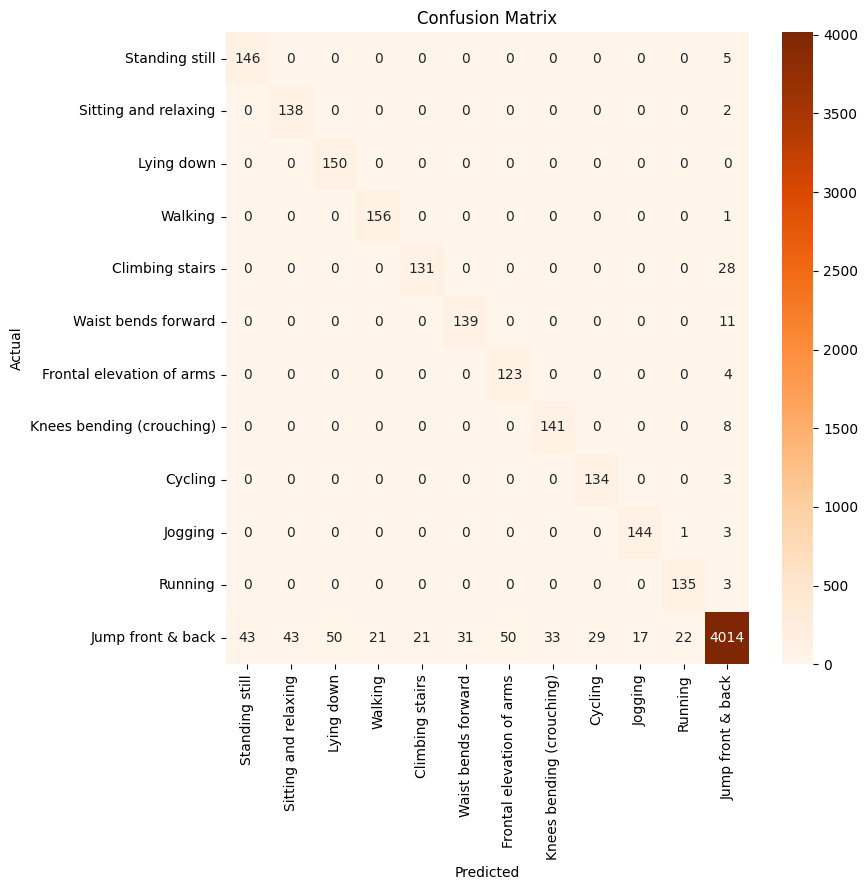

In [6]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("Classification Report:")
report = classification_report(y_true_labels, y_pred_labels, target_names=activity_labels.values())
print(report)

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(9, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=activity_labels.values(),
            yticklabels=activity_labels.values())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [7]:
accuracy = np.mean(y_pred_labels == y_true_labels)
mse = mean_squared_error(y_true_labels, y_pred_labels)
report_dict = classification_report(y_true_labels, y_pred_labels, output_dict=True)
sensitivity = np.mean([v['recall'] for k, v in report_dict.items() if isinstance(v, dict)])

specificity_list = []
for i in range(len(activity_labels)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp_fn = cm.sum() - cm[:, i].sum()
    specificity_list.append(tn / fp_fn if fp_fn != 0 else 0)
specificity = np.mean(specificity_list)

print(f"✅ Accuracy     : {accuracy*100:.2f}%")
print(f"✅ Sensitivity  : {sensitivity:.4f}")
print(f"✅ Specificity  : {specificity:.4f}")
print(f"✅ MSE          : {mse:.4f}")
print(f"✅ Training Time: {end - start:.2f} sec")


✅ Accuracy     : 92.83%
✅ Sensitivity  : 0.9530
✅ Specificity  : 0.9832
✅ MSE          : 3.6921
✅ Training Time: 451.61 sec


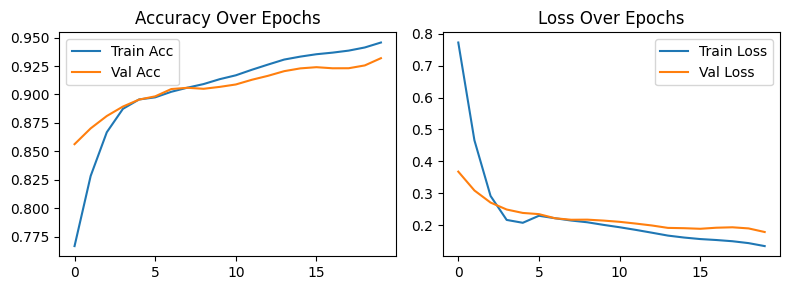

In [8]:
train_acc = savgol_filter(history.history['accuracy'], 9, 3)
val_acc = savgol_filter(history.history['val_accuracy'], 9, 3)
train_loss = savgol_filter(history.history['loss'], 9, 3)
val_loss = savgol_filter(history.history['val_loss'], 9, 3)

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.title("Accuracy Over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title("Loss Over Epochs")
plt.legend()
plt.tight_layout()
plt.show()


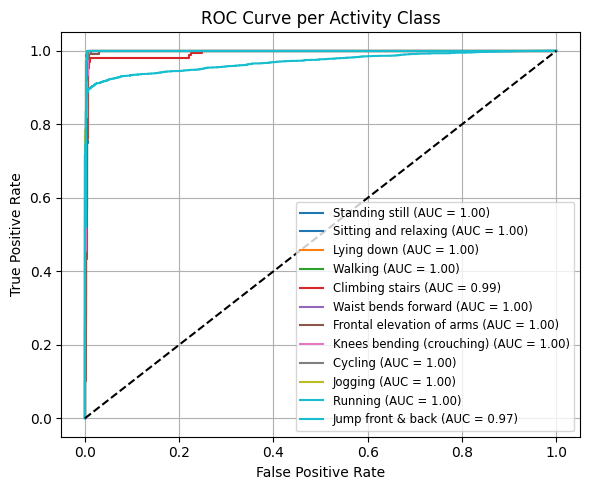

In [9]:
fpr, tpr, roc_auc = {}, {}, {}
n_classes = y_test.shape[1]
colors = plt.cm.get_cmap('tab10', n_classes).colors

plt.figure(figsize=(6, 5))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{activity_labels[i+1]} (AUC = {roc_auc[i]:.2f})", color=colors[i % len(colors)])

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve per Activity Class")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
val_loss = history.history['val_loss'][-1]
val_acc = history.history['val_accuracy'][-1]

print(f"\n🎯 Train Accuracy: {train_acc*100:.2f}% | Loss: {train_loss:.4f}")
print(f"\n📊 Val Accuracy  : {val_acc*100:.2f}%   | Loss: {val_loss:.4f}")
print(f"\n✅ Test Accuracy : {test_acc*100:.2f}% | Loss: {test_loss:.4f}")



🎯 Train Accuracy: 94.90% | Loss: 0.1271

📊 Val Accuracy  : 93.08%   | Loss: 0.1834

✅ Test Accuracy : 92.83% | Loss: 0.1807
